## 1) Data Analysis

In [9]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Shapes:
sdf: torch.Size([48, 48, 48])
grasps: torch.Size([480, 7])
scores: torch.Size([480])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



## 2) Overfitting on 1 sample

In [10]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

### 2.1) Initialize the model

In [11]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977


### 2.2) Get a small number of samples

In [12]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)

scene = dataset[0]

def get_samples(scene, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(scene['grasps']))[:num_samples]
    samples = []
    for i in indices:
        sample = {
            'grasps': scene['grasps'][i].float().to(device),
            'scores': scene['scores'][i].float().to(device),
            'sdf': scene['sdf'].float().to(device)
        }
        samples.append(sample)
    return samples

samples = get_samples(scene, 10)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasps: ", sample['grasps'].tolist())
    print("\tscore: ", sample['scores'].item())


print(samples[0]['grasps'].shape)
print(samples[0]['scores'].shape)
print(samples[0]['sdf'].shape)



Sample 0:
	grasps:  [0.03288976103067398, -0.4235876500606537, 0.20093415677547455, 0.1622592806816101, -0.16071856021881104, 0.5709341764450073, -0.14416876435279846]
	score:  1.9573743343353271
Sample 1:
	grasps:  [-0.04639378935098648, 0.005759271793067455, 0.6709341406822205, -0.1295223981142044, -0.170878067612648, 0.1809341162443161, -0.008676999248564243]
	score:  0.929709792137146
Sample 2:
	grasps:  [0.028589002788066864, -0.4741508364677429, 0.17093412578105927, 0.15106919407844543, -0.15743368864059448, 0.590934157371521, -0.1308029145002365]
	score:  -1.0003485679626465
torch.Size([7])
torch.Size([])
torch.Size([48, 48, 48])


### 2.3) Overfit on these samples from that one scene

[2.3062205954274075, 2.303736984165835, 2.302465810423564, 2.301415713092865, 2.3005105132937387, 2.299713099715882, 2.298960475145941, 2.298289549509718, 2.2976979652841694, 2.2970939746337535, 2.2965100186047493, 2.2959228638675997, 2.2953585123774247, 2.29475023838022, 2.2941662255034316, 2.293588230610476, 2.2929771291906946, 2.292390081868507, 2.2916325486585265, 2.2911155466397757, 2.2905059232056373, 2.2898534661100713, 2.2892342002363875, 2.288565125921741, 2.288072717335308, 2.287418888596585, 2.2866880498826503, 2.2859612220316192, 2.285212161601521, 2.284426288632676, 2.2837580088060347, 2.2830702054081486, 2.2823960325215014, 2.2815190626308324, 2.280671987158712, 2.2792434289352967, 2.277911917399615, 2.2768316663103176, 2.2759363509481774, 2.2746728191152217, 2.2737953047966584, 2.2727465993259104, 2.2719775449484585, 2.270829304866493, 2.2696633111685514, 2.2685999399982393, 2.2676730139181016, 2.2665162940043957, 2.265627229679376, 2.264767000777647, 2.263927267305553, 

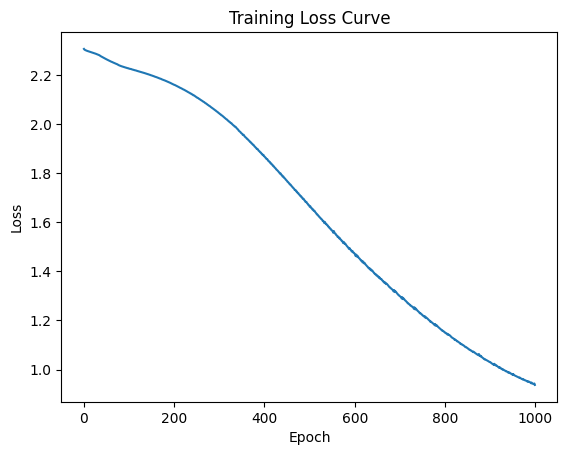

In [13]:
EPOCHS = 1000

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        sdf_features = model.encode_sdf(sample['sdf'])
        flattened_features = torch.cat([sdf_features, sample['grasps']])
        pred_quality = model(flattened_features).squeeze()
        loss = criterion(pred_quality, sample['scores'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.2) Create the datasets

In [14]:
import random

# Load the dataset
dataset = GraspDataset(data_path)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)
train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

# Shuffle indices
random.seed(42)
indices = list(range(num_samples))
random.shuffle(indices)

# Split indices
train_indices = indices[:100]
val_indices = indices[-10:]

# Create Subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Subset samples: 15547, Calculated train size: 12437, Calculated val size: 3110
Train dataset size: 100, Validation dataset size: 10


In [15]:
import random
from pathlib import Path
from dataset import GraspDataset, GraspBatchIterableDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch

# --- Configuration ---
LEARNING_RATE = 1e-4
EPOCHS = 100
VAL_SPLIT = 0.2
BASE_CHANNELS = 4
FC_DIMS = [32, 16, 8]
SCENE_BATCH_SIZE = 1 # Process one scene at a time. Increase if you have lots of system RAM.
GRASP_BATCH_SIZE = 480 # Process all 480 grasps per scene at once. Reduce if you run out of VRAM.
NUM_WORKERS = 4
GRASP_BATCH_SIZE = 32

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Dataset and Dataloaders ---
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

num_samples = len(dataset)
train_size = int(num_samples * (1 - VAL_SPLIT))
val_size = num_samples - train_size
print(f"Total scenes: {num_samples}, Train scenes: {train_size}, Val scenes: {val_size}")

indices = list(range(num_samples))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:100]
val_indices = indices[-10:]

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
print(f"Train dataset size: {len(train_set)}, Validation dataset size: {len(val_set)}")

# Create the iterable datasets
train_grasp_dataset = GraspBatchIterableDataset(train_set, grasp_batch_size=GRASP_BATCH_SIZE, shuffle_scenes=True)
val_grasp_dataset = GraspBatchIterableDataset(val_set, grasp_batch_size=GRASP_BATCH_SIZE, shuffle_scenes=False)

# The dataloader now yields your desired batches directly!
# batch_size=None is important for iterable datasets that do their own batching.
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_grasp_dataset, batch_size=None, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(val_grasp_dataset, batch_size=None, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)

# --- Model, Optimizer, Loss ---
model = GQEstimator(input_size=48, base_channels=BASE_CHANNELS, fc_dims=FC_DIMS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# --- Training Loop ---
print(f"\nStarting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    num_steps = 0

    for sdf, grasp_batch, score_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training"):
        
        optimizer.zero_grad()

        # Move to device
        sdf = sdf.to(device)
        grasp_batch = grasp_batch.to(device)
        score_batch = score_batch.to(device)

        # 1. Encode SDF
        sdf_features = model.encode_sdf(sdf)

        # 2. Expand features for the grasp batch
        expanded_sdf_features = sdf_features.expand(GRASP_BATCH_SIZE, -1)

        # 3. Concatenate features
        flattened_features = torch.cat([expanded_sdf_features, grasp_batch], dim=1)

        # 4. Predict grasp quality and compute loss
        pred_quality = model(flattened_features)
        loss = criterion(pred_quality, score_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * GRASP_BATCH_SIZE
        num_steps += GRASP_BATCH_SIZE

    avg_train_loss = total_train_loss / num_steps

    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    num_steps = 0
    with torch.no_grad():
        for sdf, grasp_batch, score_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation"):
            # Move to device
            sdf = sdf.to(device)
            grasp_batch = grasp_batch.to(device)
            score_batch = score_batch.to(device)

            # 1. Encode SDF
            sdf_features = model.encode_sdf(sdf)

            # 2. Expand features for the grasp batch
            expanded_sdf_features = sdf_features.expand(GRASP_BATCH_SIZE, -1)

            # 3. Concatenate features
            flattened_features = torch.cat([expanded_sdf_features, grasp_batch], dim=1)

            # 4. Predict grasp quality and compute loss
            pred_quality = model(flattened_features)
            loss = criterion(pred_quality, score_batch)

            total_val_loss += loss.item() * GRASP_BATCH_SIZE
            num_steps += GRASP_BATCH_SIZE


    avg_val_loss = total_val_loss / num_steps
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# --- Save Model ---
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully to {model_path}")

Using device: cpu
Total scenes: 15547, Train scenes: 12437, Val scenes: 3110
Train dataset size: 100, Validation dataset size: 10
Initializing GQEstimator
Input size: 48
Flattened size: 864
Number of parameters: 46889

Starting training for 100 epochs...


Epoch 1/100 Training: 1500it [00:13, 109.22it/s]
Epoch 1/100 Validation: 150it [00:03, 43.23it/s]


Epoch [1/100], Train Loss: 39.3668, Val Loss: 61.6466


Epoch 2/100 Training: 1500it [00:10, 141.68it/s]
Epoch 2/100 Validation: 150it [00:00, 361.14it/s]


Epoch [2/100], Train Loss: 37.5586, Val Loss: 64.6404


Epoch 3/100 Training: 1500it [00:11, 132.45it/s]
Epoch 3/100 Validation: 150it [00:00, 353.47it/s]


Epoch [3/100], Train Loss: 43.1828, Val Loss: 61.3789


Epoch 4/100 Training: 464it [00:03, 130.84it/s]


KeyboardInterrupt: 